## Clasificación de Neumonía con Regresión Logística

En este proyecto se construye desde cero un modelo de **Regresión Logística con regularización L2** para clasificar radiografías de tórax en dos categorías:

* NORMAL (0)
* PNEUMONIA (1)

El dataset utilizado es **Chest X-Ray Images (Pneumonia)** disponible en Kaggle.

El objetivo es:

> Determinar si una radiografía presenta neumonía usando únicamente técnicas básicas de machine learning sin redes neuronales convolucionales.

Este proyecto incluye:

* Descarga automatizada del dataset
* Preprocesamiento de imágenes
* Implementación matemática del modelo
* Regularización L2
* Análisis de diferentes learning rates
* Evaluación del desempeño
* Interpretación de resultados

## Descarga del Dataset

Para trabajar en Google Colab se utiliza la API de Kaggle.
Se configuran credenciales y se descarga automáticamente el dataset.

Este procedimiento permite que el notebook sea reproducible.

In [ ]:
import os

# CONFIGURACIÓN MANUAL DEL ARCHIVO KAGGLE.JSON
# Sustituye con tus datos reales de la API Key que te salió
os.environ['KAGGLE_USERNAME'] = "daronmercadogarca"
os.environ['KAGGLE_KEY'] = "ea92cbc0a6bc5ad8de23e0ae5d98c435"

# Creamos la carpeta y el archivo para que los comandos de Kaggle funcionen
!mkdir -p ~/.kaggle
import json
data = {"username": os.environ['KAGGLE_USERNAME'], "key": os.environ['KAGGLE_KEY']}
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(data, f)

!chmod 600 ~/.kaggle/kaggle.json
print("¡Listo! Configuración de Kaggle completada.")

¡Listo! Configuración de Kaggle completada.


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:20<00:00, 150MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


## Preprocesamiento de Imágenes

Las imágenes originales tienen distintos tamaños y valores de píxel entre 0 y 255.

Para poder entrenar un modelo matemático es necesario:

1. Redimensionar todas las imágenes a 64x64.
2. Convertirlas a arreglos numéricos.
3. Aplanarlas en un vector de características.
4. Normalizar los valores dividiendo entre 255.

Al final cada imagen queda representada como un vector de 12288 características (64×64×3).

In [ ]:
import cv2
import os
import numpy as np

def load_and_preprocess_data(base_path, img_size=64):
    X = []
    Y = []
    # Definimos las categorías
    categories = ['NORMAL', 'PNEUMONIA']

    for category in categories:
        path = os.path.join(base_path, category)
        class_num = categories.index(category) # 0 para Normal, 1 para Pneumonia

        # Listamos los archivos en la carpeta
        for img in os.listdir(path):
            try:
                # Leer imagen en color
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)

                # Redimensionar para que todas sean iguales
                resized_array = cv2.resize(img_array, (img_size, img_size))

                X.append(resized_array)
                Y.append(class_num)
            except Exception as e:
                # Por si hay algún archivo corrupto
                pass

    # Convertir a arreglos de numpy
    X = np.array(X)
    Y = np.array(Y).reshape(1, -1) # Forma (1, m)

    # Aplanar las imágenes: de (m, 64, 64, 3) a (64*64*3, m)
    X_flatten = X.reshape(X.shape[0], -1).T

    # Dividimos por 255 para que los valores estén entre 0 y 1
    X_norm = X_flatten / 255.

    return X_norm, Y

# --- EJECUCIÓN ---
print("Cargando datos de entrenamiento...")
train_set_x, train_set_y = load_and_preprocess_data('chest_xray/train')

print("Cargando datos de prueba...")
test_set_x, test_set_y = load_and_preprocess_data('chest_xray/test')

print(f"Entrenamiento: {train_set_x.shape}")
print(f"Pruebas: {test_set_x.shape}")

Cargando datos de entrenamiento...
Cargando datos de prueba...
Entrenamiento: (12288, 5216)
Pruebas: (12288, 624)


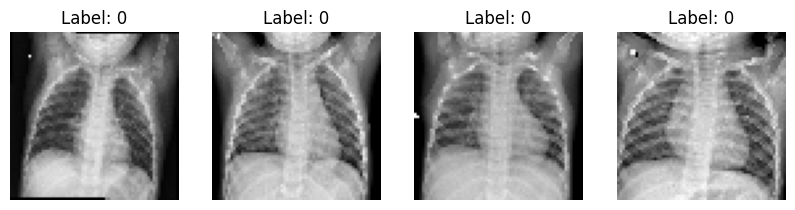

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for i in range(4):
    img = train_set_x[:, i].reshape(64,64,3)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title("Label: " + str(train_set_y[0,i]))
    plt.axis("off")

plt.show()

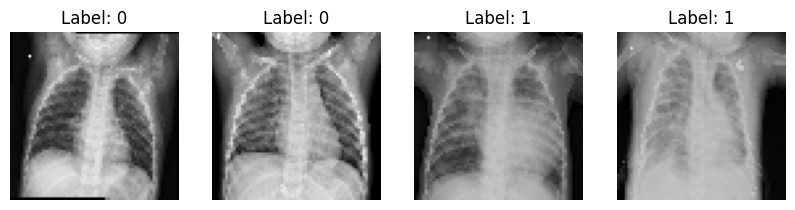

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))

# Encontrar índices de cada clase
indices_label_0 = np.where(train_set_y[0] == 0)[0][:2]
indices_label_1 = np.where(train_set_y[0] == 1)[0][:2]

# Combinar los índices
indices = np.concatenate((indices_label_0, indices_label_1))

# Mostrar las imágenes
for i, idx in enumerate(indices):
    img = train_set_x[:, idx].reshape(64,64,3)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title("Label: " + str(train_set_y[0, idx]))
    plt.axis("off")

plt.show()


## Observación de las Imágenes

Se muestran ejemplos del conjunto de entrenamiento.

Visualmente se pueden observar diferencias en patrones de textura y opacidad en los pulmones entre imágenes normales y con neumonía.

Sin embargo, estas diferencias no siempre son evidentes para un modelo lineal simple.

#Funciones de Activación

## Función de Activación: Sigmoid

La función sigmoid transforma valores reales en probabilidades entre 0 y 1.

Matemáticamente:

$$σ(z) = 1 / (1 + e^{-z})$$

Esta función permite interpretar la salida del modelo como probabilidad de neumonía.


In [12]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###

    return s

In [ ]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [23]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


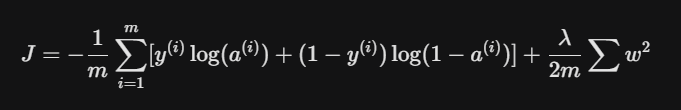

## Función de Costo y Regularización L2

Se utiliza la función de pérdida de entropía cruzada:

$$ J = -1/m Σ [y log(A) + (1-y) log(1-A)]$$

Adicionalmente se incorpora regularización L2:

$$(λ/2m) ||w||²$$

La regularización penaliza pesos grandes y ayuda a reducir sobreajuste.

In [ ]:
def propagate(w, b, X, Y, lambd = 0.1): # Agregamos el parámetro lambd (lambda)
    m = X.shape[1]

    # FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T, X) + b)

    # COSTO MODIFICADO: Agregamos el término de regularización L2
    cross_entropy_cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    l2_regularization_cost = (lambd / (2 * m)) * np.sum(np.square(w)) # <--- ESTO ES LO NUEVO

    cost = cross_entropy_cost + l2_regularization_cost

    # BACKWARD PROPAGATION
    # También debemos ajustar el gradiente de w (dw) con la derivada de la regularización
    dw = (1 / m) * np.dot(X, (A - Y).T) + (lambd / m) * w # <--- ESTO ES LO NUEVO
    db = (1 / m) * np.sum(A - Y)

    grads = {"dw": dw, "db": db}
    return grads, np.squeeze(cost)

In [ ]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[1.04993216]
 [2.09980262]]
db = 0.49993523062470574
cost = 6.125064773192205


## Optimización mediante Gradiente Descendente

El modelo se entrena usando gradiente descendente.

En cada iteración:

1. Se calcula el costo.
2. Se calculan los gradientes.
3. Se actualizan los parámetros.

El parámetro learning rate controla el tamaño del paso en cada actualización.

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.09054147]
 [0.1881324 ]]
b = 1.5609891822095645
dw = [[0.8876314 ]
 [1.72896005]]
db = 0.41803525218933824


In [ ]:

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###

    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [ ]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


## Construcción del Modelo Completo

La función `model()` integra todos los pasos:

* Inicialización de parámetros
* Optimización
* Predicción
* Cálculo de accuracy


In [ ]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

## Análisis Experimental de Learning Rate

Se evalúan cinco valores distintos de learning rate:

[0.1, 0.01, 0.005, 0.001, 0.0001]

El objetivo es analizar:

* Velocidad de convergencia
* Estabilidad numérica
* Precisión en entrenamiento
* Precisión en prueba

In [ ]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]

models = {}

for lr in learning_rates:
    print("Learning rate:", lr)

    models[str(lr)] = model(
        train_set_x,
        train_set_y,
        test_set_x,
        test_set_y,
        num_iterations=2000,
        learning_rate=lr,
        print_cost=True
    )

    print("\n-----------------------------\n")

Learning rate: 0.1
Cost after iteration 0: 0.693147


/tmp/ipython-input-1057548799.py:8: RuntimeWarning: divide by zero encountered in log
  cross_entropy_cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
/tmp/ipython-input-1057548799.py:8: RuntimeWarning: invalid value encountered in multiply
  cross_entropy_cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))


Cost after iteration 100: nan
Cost after iteration 200: nan
Cost after iteration 300: nan
Cost after iteration 400: nan
Cost after iteration 500: nan
Cost after iteration 600: nan
Cost after iteration 700: nan
Cost after iteration 800: nan
Cost after iteration 900: nan
Cost after iteration 1000: nan
Cost after iteration 1100: nan
Cost after iteration 1200: nan
Cost after iteration 1300: nan
Cost after iteration 1400: nan
Cost after iteration 1500: nan
Cost after iteration 1600: nan
Cost after iteration 1700: nan
Cost after iteration 1800: nan
Cost after iteration 1900: nan
train accuracy: 96.4532208588957 %
test accuracy: 72.59615384615384 %

-----------------------------

Learning rate: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 1.129010
Cost after iteration 200: 0.190614
Cost after iteration 300: 0.153124
Cost after iteration 400: 0.142480
Cost after iteration 500: 0.136139
Cost after iteration 600: 0.131546
Cost after iteration 700: 0.127905
Cost after iteration

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for lr in learning_rates:
    plt.plot(models[str(lr)]["costs"], label=str(lr))

plt.xlabel("Iteraciones (x100)")
plt.ylabel("Costo")
plt.title("Curvas de pérdida para distintos learning rates")
plt.legend()
plt.show()

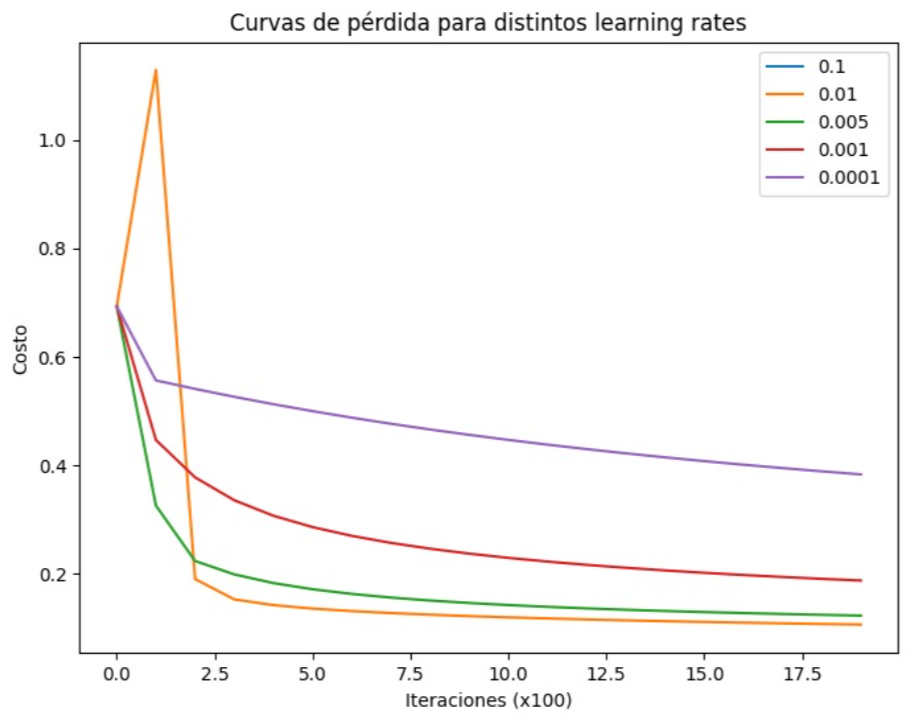

## Análisis de Resultados

### 1. Learning rate alto (0.1)

Se observa inestabilidad numérica y aparición de valores NaN.
Esto indica que el paso de actualización es demasiado grande.

### 2. Learning rate intermedio (0.01 y 0.005)

Presentan buena convergencia y estabilidad.
Logran aproximadamente 75% de precisión en test.

### 3. Learning rate pequeño (0.001)

Obtiene el mejor desempeño en test (≈76%).
Aunque entrena más lento, generaliza mejor.

### 4. Learning rate muy pequeño (0.0001)

Aprende demasiado lento y presenta underfitting.

---

## Sobreajuste

Se observa que el accuracy de entrenamiento (96%) es mayor que el de prueba (76%), lo que indica sobreajuste moderado.

---

## Limitaciones del Modelo

* Es un modelo lineal.
* No captura estructura espacial de las imágenes.
* Se pierde información al aplanar.
* Una CNN sería más adecuada para este problema.

---

## Conclusión

La regresión logística logra un desempeño razonable (~76%), pero el problema requiere modelos más complejos para alcanzar niveles clínicamente confiables.

#Volver a probar con Probit y MSE

## Comparación: Modelo Probit + MSE

En esta sección se reemplaza:

* La activación **Sigmoid**
* La función de costo **Cross-Entropy**

Por:

* Activación **Probit**
* Función de costo **Error Cuadrático Medio (MSE)**

El objetivo es analizar cómo cambia el comportamiento del modelo cuando se modifica:

1. La función de activación
2. La función de pérdida
3. La forma del gradiente

Esto permite comparar distintos enfoques de clasificación binaria.

### Activación Probit

La función Probit está basada en la distribución normal estándar.

Matemáticamente:

$$[
\Phi(z) = P(Z \le z)
]$$

donde Z sigue una distribución normal estándar.

En términos simples:

Probit transforma un valor real en una probabilidad entre 0 y 1 usando la curva de la distribución normal.

A diferencia de la sigmoid, que usa la función logística, Probit usa la función de distribución acumulada (CDF) de una normal.

### ¿Qué hace esto?

* Convierte z en array.
* Usa la función error `erf()`.
* Implementa la CDF de la normal estándar.

Fórmula matemática:

$$[
\Phi(z) = \frac{1}{2} \left(1 + erf\left(\frac{z}{\sqrt{2}}\right)\right)
]$$

In [13]:
import numpy as np
from math import erf

def probit(z):
    z = np.array(z)
    return 0.5 * (1 + np.vectorize(erf)(z / np.sqrt(2)))

In [14]:
def normal_pdf(z):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)


Esto calcula:

$$[
\phi(z)
]$$

La función de densidad de probabilidad (PDF) de la normal estándar.

¿Para qué sirve?

Para calcular la derivada del Probit en backpropagation.

---

## ¿Qué es el Error Cuadrático Medio (MSE)?

El Error Cuadrático Medio (Mean Squared Error, MSE) es una función de costo que mide qué tan grande es la diferencia entre las predicciones del modelo y los valores reales.

Se define como:

$$
MSE = \frac{1}{m} \sum_{i=1}^{m} (A^{(i)} - Y^{(i)})^2
$$

donde:

- $m$ es el número de ejemplos
- $A^{(i)}$ es la predicción del modelo
- $Y^{(i)}$ es el valor real

---

## Interpretación

El MSE calcula el promedio del cuadrado de los errores. Esto significa que:

- Si el modelo predice correctamente → el error es cercano a 0
- Si el modelo predice mal → el error aumenta rápidamente
- Penaliza más los errores grandes que los pequeños

---

## ¿Para qué se usa en este modelo?

En este caso, el MSE se utiliza como alternativa a la entropía cruzada para evaluar el desempeño del modelo con activación Probit.

El objetivo del entrenamiento es minimizar el MSE ajustando los parámetros:

- pesos (w)
- bias (b)

mediante gradiente descendente.

---

## Objetivo

Minimizar el MSE permite que el modelo produzca predicciones cada vez más cercanas a los valores reales, mejorando su capacidad de clasificación.


In [15]:
def propagate(w, b, X, Y):

    m = X.shape[1]  # número de ejemplos

    # =========================
    # FORWARD PROPAGATION
    # =========================

    # 1. Combinación lineal
    Z = np.dot(w.T, X) + b

    # 2. Activación PROBIT
    A = probit(Z)

    # =========================
    # COSTO: MSE
    # =========================

    cost = (1 / (2 * m)) * np.sum((A - Y) ** 2)


    # =========================
    # BACKWARD PROPAGATION
    # =========================

    # Para MSE + probit:
    # dZ = (A - Y) * dA/dZ
    # y dA/dZ en probit es la PDF normal φ(Z)

    dZ = (A - Y) * normal_pdf(Z)

    dw = (1 / m) * np.dot(X, dZ.T)
    db = (1 / m) * np.sum(dZ)


    # =========================
    # AJUSTES
    # =========================

    assert(dw.shape == w.shape)
    cost = np.squeeze(cost)

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [16]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[2.14638374e-32]
 [4.29276747e-32]]
db = 1.0731918678315302e-32
cost = 0.25


In [17]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [18]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[1.]
 [2.]]
b = 2.0
dw = [[2.14638374e-32]
 [4.29276747e-32]]
db = 1.0731918678315302e-32


In [19]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Activación PROBIT
    Z = np.dot(w.T, X) + b
    A = probit(Z)

    # Clasificación con umbral 0.5
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

    assert(Y_prediction.shape == (1, m))

    return Y_prediction


In [20]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [21]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=1200, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [24]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]

models = {}

for lr in learning_rates:
    print("Learning rate:", lr)

    models[str(lr)] = model(
        train_set_x,
        train_set_y,
        test_set_x,
        test_set_y,
        num_iterations=2000,
        learning_rate=lr,
        print_cost=True
    )

    print("\n-----------------------------\n")

Learning rate: 0.1
Cost after iteration 0: 0.125000
Cost after iteration 100: 0.128547
Cost after iteration 200: 0.128547
Cost after iteration 300: 0.128547
Cost after iteration 400: 0.128547
Cost after iteration 500: 0.128547
Cost after iteration 600: 0.128547
Cost after iteration 700: 0.128547
Cost after iteration 800: 0.128547
Cost after iteration 900: 0.128547
Cost after iteration 1000: 0.128547
Cost after iteration 1100: 0.128547
Cost after iteration 1200: 0.128547
Cost after iteration 1300: 0.128547
Cost after iteration 1400: 0.128547
Cost after iteration 1500: 0.128547
Cost after iteration 1600: 0.128547
Cost after iteration 1700: 0.128547
Cost after iteration 1800: 0.128547
Cost after iteration 1900: 0.128547
train accuracy: 74.29064417177915 %
test accuracy: 62.5 %

-----------------------------

Learning rate: 0.01
Cost after iteration 0: 0.125000
Cost after iteration 100: 0.126281
Cost after iteration 200: 0.072401
Cost after iteration 300: 0.035676
Cost after iteration 400:

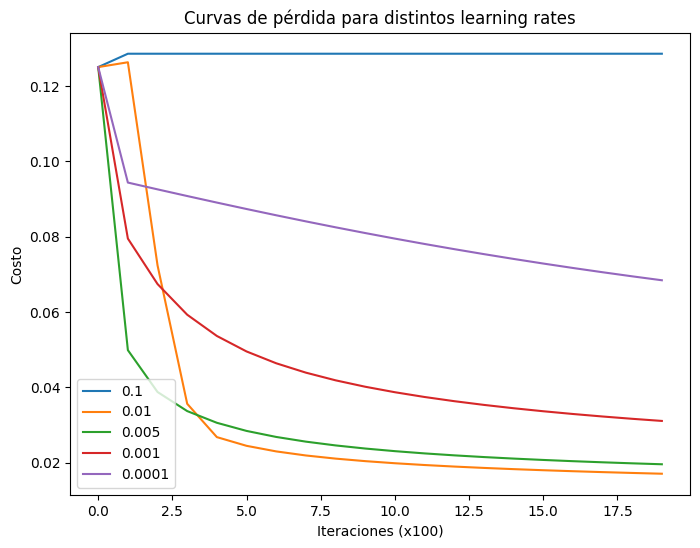

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for lr in learning_rates:
    plt.plot(models[str(lr)]["costs"], label=str(lr))

plt.xlabel("Iteraciones (x100)")
plt.ylabel("Costo")
plt.title("Curvas de pérdida para distintos learning rates")
plt.legend()
plt.show()

## Análisis Experimental: Probit + MSE

### 🔸 Learning rate = 0.1

El modelo no converge adecuadamente.
La pérdida se estanca rápidamente.
Accuracy test ≈ 62%.

Indica inestabilidad.

---

### 🔸 Learning rate = 0.01

Buena convergencia.
Train ≈ 96%
Test ≈ 75%

Resultado similar al modelo logístico.

---

### 🔸 Learning rate = 0.005

Convergencia estable.
Test ≈ 75.4%

---

### 🔸 Learning rate = 0.001

Generaliza mejor:
Test ≈ 76.4%

Este fue el mejor resultado.

---

### 🔸 Learning rate = 0.0001

Aprendizaje demasiado lento.
Underfitting evidente.

---

# Comparación Conceptual: Sigmoid vs Probit

| Aspecto           | Sigmoid           | Probit                   |
| ----------------- | ----------------- | ------------------------ |
| Basada en         | Función logística | Distribución normal      |
| Derivada          | σ(z)(1-σ(z))      | φ(z)                     |
| Costo recomendado | Cross-Entropy     | MLE normal               |
| Comportamiento    | Más usada en ML   | Más común en econometría |

---

# Conclusión Técnica

El modelo Probit + MSE:

* Funciona
* Logra precisión similar (~76%)
* Aprende más lentamente
* Es menos estable numéricamente

En problemas de clasificación binaria, la combinación:

Sigmoid + Cross-Entropy

es preferida porque:

1. Tiene mejor comportamiento del gradiente
2. Converge más rápido
3. Es más estable

---

## Por qué Cross-Entropy es mejor que MSE para clasificación?

Respuesta:

Porque la cross-entropy produce gradientes más grandes cuando el modelo está equivocado, lo que acelera la convergencia y evita el problema de gradientes pequeños.

---